In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

from gnnboundary import *

### Load Dataset

In [32]:
seed = 12345
dataset_name = "motif"

datasets = {
 "collab": CollabDataset(seed=seed),
 "motif": MotifDataset(seed=seed),
 "enzymes": ENZYMESDataset(seed=seed)
}

dataset = datasets[dataset_name]

### Load Model

In [35]:
config = {
    "node_features": len(dataset.NODE_CLS),
    "num_classes": len(dataset.GRAPH_CLS),
}

match dataset_name:
    case "collab":
        config["hidden_channels"] = 64
        config["num_layers"] = 5
    case "motif":
        config["hidden_channels"] = 6
        config["num_layers"] = 3
    case "enzymes":
        config["hidden_channels"] = 32
        config["num_layers"] = 3
    case _:
        pass

model = GCNClassifier(**config)
model.load_state_dict(torch.load(f"ckpts/{dataset_name}.pt"))

<All keys matched successfully>

In [36]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\40774\miniconda3\envs\gnnboundary\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\40774\miniconda3\envs\gnnboundary\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Evaluate Model

In [37]:
evaluation = dataset.model_evaluate(model, use_test_only=False)
evaluation

{'acc': 0.9584597945213318,
 'cm': array([[2622,   27,  194,    0],
        [  12, 2898,    0,   44],
        [ 199,    1, 2732,    0],
        [   0,    2,    0, 2800]], dtype=int64),
 'f1': {'house': 0.9238900542259216,
  'house_x': 0.9853790998458862,
  'comp_4': 0.9327415227890015,
  'comp_5': 0.9918526411056519}}

Plot saved as: .\figures\confusion_matrix\from_checkpoints\motif_confusion_all.jpg


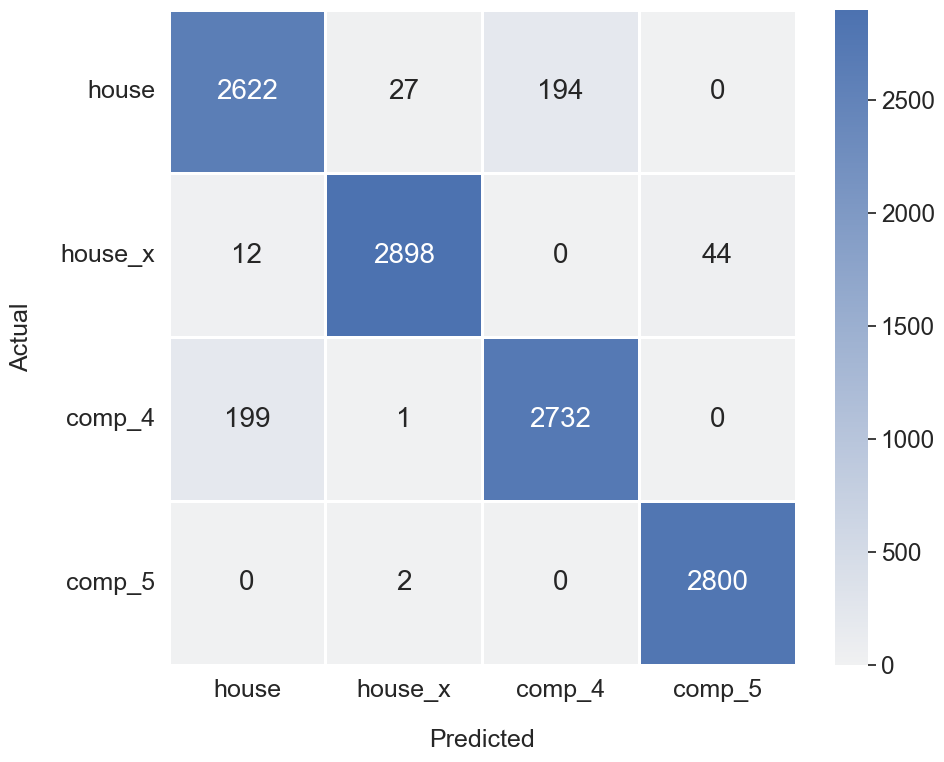

In [39]:
draw_matrix(
    evaluation['cm'], 
    dataset.GRAPH_CLS.values(), 
    fmt='d', 
    file_name=f"{dataset_name}_confusion_all.jpg", 
    save_path=".\\figures\\confusion_matrix\\from_checkpoints")

### Compute adjacency

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\40774\miniconda3\envs\gnnboundary\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 10/10 [05:10<00:00, 31.00s/it]


Plot saved as: .\figures\adjacency_matrix\from_checkpoints\enzymes_adjacency.jpg


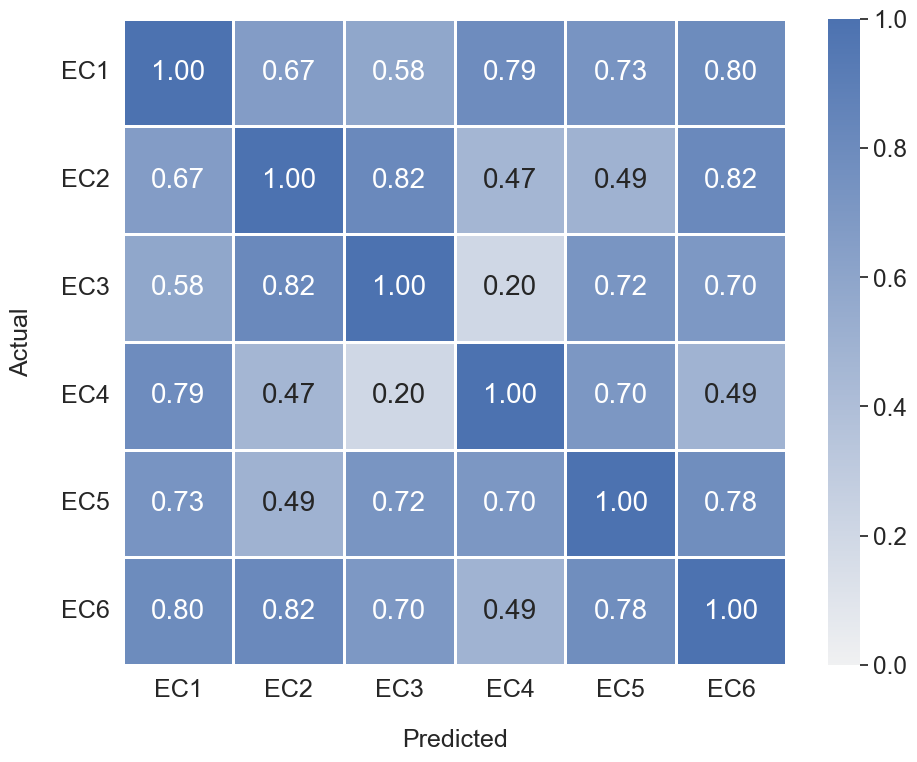

In [11]:
from tqdm import tqdm

experiment_results = []

for _ in tqdm(range(10)):
    adj_ratio_mat, _ = pairwise_boundary_analysis(model, dataset_list_pred)
    experiment_results.append(adj_ratio_mat)

result = np.array(experiment_results).mean(axis=0)
draw_matrix(
    result, 
    names=dataset.GRAPH_CLS.values(), 
    fmt='.2f',
    file_name=f"{dataset_name}_adjacency.jpg", 
    save_path=".\\figures\\adjacency_matrix\\from_checkpoints")